# Combining things together for CMIP6

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os, glob, json
import matplotlib.pyplot as plt

## Historical Daily

In [44]:
path = 'shared/data/gdfl/historical_daily/'

# create a dictionary to store all datasets
data = {}
for file_path in glob.glob(os.path.join(path, '*.nc')):
    file_name = os.path.basename(file_path)
    data[file_name.split('.')[0]] = xr.open_dataarray(file_path)

In [45]:
# combine wind elements together
wind = xr.combine_by_coords([
    data['uas'],
    data['vas'],
    data['sfcWind']
])

In [46]:
wind = wind.drop('height')

In [47]:
wind

<xarray.Dataset>
Dimensions:  (lat: 44, lon: 48, time: 60225)
Coordinates:
  * lat      (lat) float64 -11.5 -10.5 -9.5 -8.5 -7.5 ... 28.5 29.5 30.5 31.5
  * lon      (lon) float64 43.12 44.38 45.62 46.88 ... 98.12 99.38 100.6 101.9
  * time     (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Data variables:
    sfcWind  (time, lat, lon) float32 ...
    uas      (time, lat, lon) float32 ...
    vas      (time, lat, lon) float32 ...

In [7]:
# model everything after wind components
wind['tos'] = (['time', 'lat', 'lon'], data['tos'].interp_like(wind).transpose(
  'time', 'lat', 'lon'  
).values)

In [8]:
wind['tas'] = (['time', 'lat', 'lon'], data['tas'].interp_like(wind).transpose(
  'time', 'lat', 'lon' 
).values)

In [9]:
wind['pr'] = (['time', 'lat', 'lon'], data['pr'].interp_like(wind).transpose(
  'time', 'lat', 'lon' 
).values)

In [11]:
wind['psl'] = (['time', 'lat', 'lon'], data['psl'].interp_like(wind).transpose(
  'time', 'lat', 'lon'  
).values)

In [12]:
# add attributes
wind.tos.attrs = data['tos'].attrs
wind.tas.attrs = data['tas'].attrs
wind.psl.attrs = data['psl'].attrs
wind.pr.attrs = data['pr'].attrs

In [13]:
with open(os.path.join(path, 'attr_template.json')) as f:
    attr = json.load(f)

In [14]:
wind.attrs = attr

In [15]:
chunk_size = {'lat': wind.lat.shape[0], 'lon': wind.lon.shape[0], 'time': 1000}

In [16]:
for var in wind.data_vars:
    if str(wind[var].dtype) == 'float64':
        wind[var].values = wind[var].astype('float32')
    if 'chunks' in list(wind[var].encoding.keys()):
        del wind[var].encoding['chunks']

In [51]:
ds = wind.chunk(chunk_size)

In [52]:
ds

<xarray.Dataset>
Dimensions:  (lat: 44, lon: 48, time: 60225)
Coordinates:
  * lat      (lat) float64 -11.5 -10.5 -9.5 -8.5 -7.5 ... 28.5 29.5 30.5 31.5
  * lon      (lon) float64 43.12 44.38 45.62 46.88 ... 98.12 99.38 100.6 101.9
  * time     (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Data variables:
    sfcWind  (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    uas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    vas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    tos      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    psl      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            pr
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-09-17;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/d4ce73dd-d8e0-44ef-847a-b957a138daf6...
    version_id:             v20180701

In [23]:
list(wind.coords.keys())

['lat', 'lon', 'time']

In [53]:
ds.to_zarr(os.path.join(path,'../../CMIP6_HIST_DAILY.zarr'))

## SSP245_daily

In [54]:
path = 'shared/data/gdfl/ssp245_daily/'

# load data
data = {}

for file_path in glob.glob(os.path.join(path, '*.nc')):
    file_name = os.path.basename(file_path)
    data[file_name.split('.')[0]] = xr.open_dataarray(file_path)

# build dataset
ds = xr.combine_by_coords([
    data['uas'],
    data['vas'],
    data['sfcWind']
])

# drop redundant coordinates (if exists)
if 'height' in list(ds.coords.keys()):
    ds = ds.drop(['height'])


In [55]:
dim_order = ds[list(ds.data_vars)[0]].dims
# add the remaining variables
for ele in ['tos', 'tas', 'psl', 'pr']:
    # reshape data for consistency
    ds[ele] = (dim_order, data[ele].interp_like(ds).transpose(
        dim_order[0], dim_order[1], dim_order[2]
    ).values)
    ds[ele].attrs = data[ele].attrs

In [58]:
# add dataset attribute, chunking, and reset data types
with open(os.path.join(path, 'attr_template.json')) as f:
    attr = json.load(f)
for var in ds.data_vars:
    if str(ds[var].dtype) == 'float64':
        ds[var].values = ds[var].astype('float32')
    if 'chunks' in list(ds[var].encoding.keys()):
        del ds[var].encoding['chunks']

chunk_size = {'lat': wind.lat.shape[0], 'lon': wind.lon.shape[0], 'time': 1000}
ds = ds.chunk(chunk_size)
ds.attrs = attr

In [ ]:
ds.to_zarr(os.path.join(path, '../../CMIP6_SSP245_DAILY.zarr'))


## SSP585_daily

In [61]:
path = 'shared/data/gdfl/ssp585_daily/'

# load data
data = {}

for file_path in glob.glob(os.path.join(path, '*.nc')):
    file_name = os.path.basename(file_path)
    data[file_name.split('.')[0]] = xr.open_dataarray(file_path)

# build dataset
ds = xr.combine_by_coords([
    data['uas'],
    data['vas'],
    data['sfcWind']
])

# drop redundant coordinates (if exists)
if 'height' in list(ds.coords.keys()):
    ds = ds.drop(['height'])


In [62]:
dim_order = ds[list(ds.data_vars)[0]].dims
# add the remaining variables
for ele in ['tos', 'tas', 'psl', 'pr']:
    # reshape data for consistency
    ds[ele] = (dim_order, data[ele].interp_like(ds).transpose(
        dim_order[0], dim_order[1], dim_order[2]
    ).values)
    ds[ele].attrs = data[ele].attrs

In [63]:
# add dataset attribute, chunking, and reset data types
with open(os.path.join(path, 'attr_template.json')) as f:
    attr = json.load(f)
for var in ds.data_vars:
    if str(ds[var].dtype) == 'float64':
        ds[var].values = ds[var].astype('float32')
    if 'chunks' in list(ds[var].encoding.keys()):
        del ds[var].encoding['chunks']

chunk_size = {'lat': wind.lat.shape[0], 'lon': wind.lon.shape[0], 'time': 1000}
ds = ds.chunk(chunk_size)
ds.attrs = attr

In [64]:
ds

<xarray.Dataset>
Dimensions:  (lat: 44, lon: 48, time: 31390)
Coordinates:
  * lat      (lat) float64 -11.5 -10.5 -9.5 -8.5 -7.5 ... 28.5 29.5 30.5 31.5
  * lon      (lon) float64 43.12 44.38 45.62 46.88 ... 98.12 99.38 100.6 101.9
  * time     (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
Data variables:
    sfcWind  (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    uas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    vas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    tos      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    psl      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-11-15;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/b5b4d4ab-bcce-4993-907a-2184b25a2f78...
    version_id:             v20180701

In [65]:
ds.to_zarr(os.path.join(path, '../../CMIP6_SSP585_DAILY.zarr'))


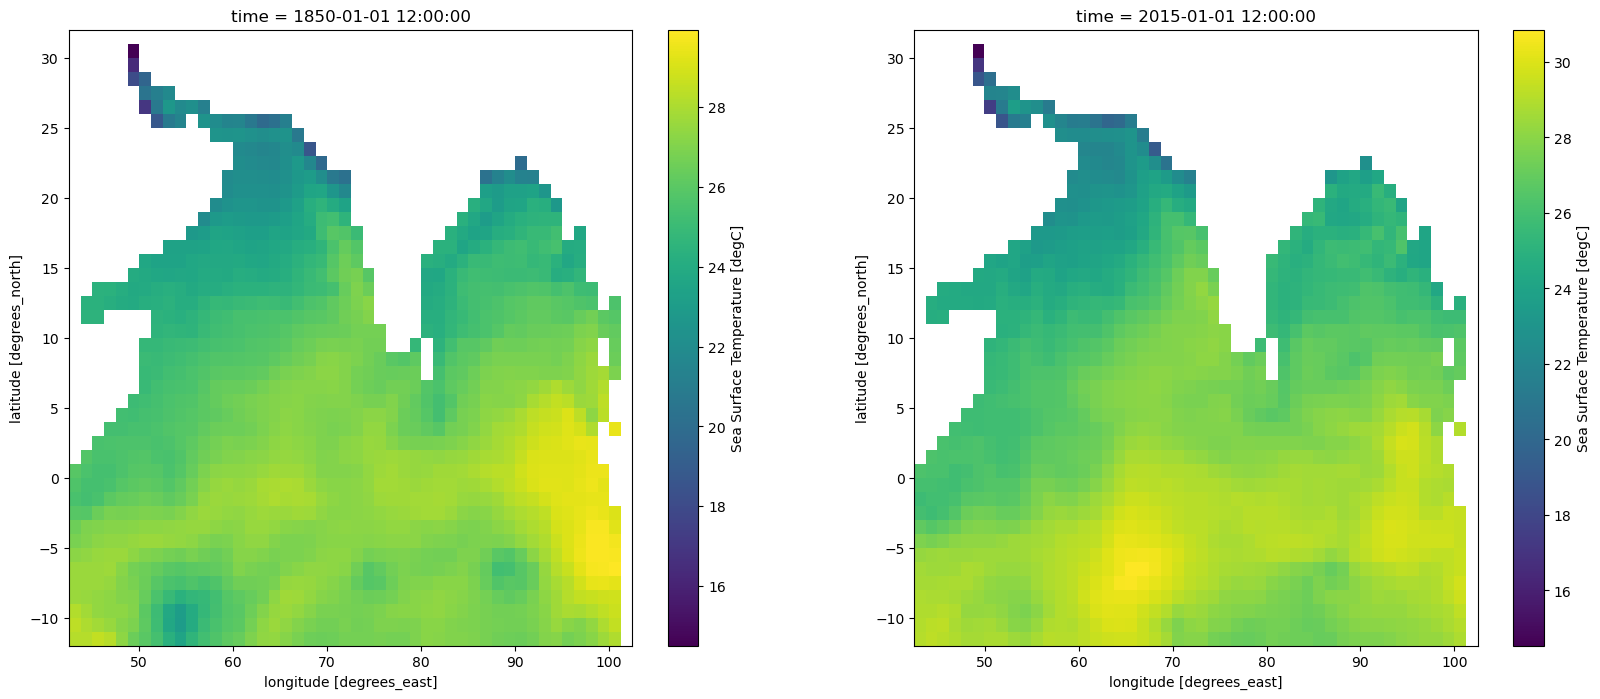

In [68]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 8))
wind.tos.isel(time=0).plot.imshow(ax=ax1)
ds.tos.isel(time=0).plot.imshow(ax=ax2)

## Historical_monthly

In [69]:
path = 'shared/data/gdfl/historical_monthly//'

# load data
data = {}

for file_path in glob.glob(os.path.join(path, '*.nc')):
    file_name = os.path.basename(file_path)
    data[file_name.split('.')[0]] = xr.open_dataarray(file_path)

# build dataset
ds = xr.combine_by_coords([
    data['uas'],
    data['vas'],
    data['sfcWind']
])

# drop redundant coordinates (if exists)
if 'height' in list(ds.coords.keys()):
    ds = ds.drop(['height'])


In [70]:
dim_order = ds[list(ds.data_vars)[0]].dims
# add the remaining variables
for ele in ['tos', 'tas', 'psl', 'pr', 'sos']:
    # reshape data for consistency
    ds[ele] = (dim_order, data[ele].interp_like(ds).transpose(
        dim_order[0], dim_order[1], dim_order[2]
    ).values)
    ds[ele].attrs = data[ele].attrs

In [71]:
# add dataset attribute, chunking, and reset data types
with open(os.path.join(path, 'attr_template.json')) as f:
    attr = json.load(f)
for var in ds.data_vars:
    if str(ds[var].dtype) == 'float64':
        ds[var].values = ds[var].astype('float32')
    if 'chunks' in list(ds[var].encoding.keys()):
        del ds[var].encoding['chunks']

chunk_size = {'lat': wind.lat.shape[0], 'lon': wind.lon.shape[0], 'time': 1000}
ds = ds.chunk(chunk_size)
ds.attrs = attr

In [72]:
ds

<xarray.Dataset>
Dimensions:  (lat: 44, lon: 48, time: 1980)
Coordinates:
  * lat      (lat) float64 -11.5 -10.5 -9.5 -8.5 -7.5 ... 28.5 29.5 30.5 31.5
  * lon      (lon) float64 43.12 44.38 45.62 46.88 ... 98.12 99.38 100.6 101.9
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    sfcWind  (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    uas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    vas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    tos      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    psl      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    sos      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-11-16;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/e3b86300-29b2-4220-97ce-40fa504858e5...
    version_id:             v20180701

In [73]:
ds.to_zarr(os.path.join(path, '../../CMIP6_HIST_MONTHLY.zarr'))

## SSP245_MONTHLY

In [74]:
path = 'shared/data/gdfl/ssp245_monthly//'

# load data
data = {}

for file_path in glob.glob(os.path.join(path, '*.nc')):
    file_name = os.path.basename(file_path)
    data[file_name.split('.')[0]] = xr.open_dataarray(file_path)

# build dataset
ds = xr.combine_by_coords([
    data['uas'],
    data['vas'],
    data['sfcWind']
])

# drop redundant coordinates (if exists)
if 'height' in list(ds.coords.keys()):
    ds = ds.drop(['height'])


In [75]:
dim_order = ds[list(ds.data_vars)[0]].dims
# add the remaining variables
for ele in ['tos', 'tas', 'psl', 'pr', 'sos']:
    # reshape data for consistency
    ds[ele] = (dim_order, data[ele].interp_like(ds).transpose(
        dim_order[0], dim_order[1], dim_order[2]
    ).values)
    ds[ele].attrs = data[ele].attrs

In [76]:
# add dataset attribute, chunking, and reset data types
with open(os.path.join(path, 'attr_template.json')) as f:
    attr = json.load(f)
for var in ds.data_vars:
    if str(ds[var].dtype) == 'float64':
        ds[var].values = ds[var].astype('float32')
    if 'chunks' in list(ds[var].encoding.keys()):
        del ds[var].encoding['chunks']

chunk_size = {'lat': wind.lat.shape[0], 'lon': wind.lon.shape[0], 'time': 1000}
ds = ds.chunk(chunk_size)
ds.attrs = attr

In [72]:
ds

<xarray.Dataset>
Dimensions:  (lat: 44, lon: 48, time: 1980)
Coordinates:
  * lat      (lat) float64 -11.5 -10.5 -9.5 -8.5 -7.5 ... 28.5 29.5 30.5 31.5
  * lon      (lon) float64 43.12 44.38 45.62 46.88 ... 98.12 99.38 100.6 101.9
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    sfcWind  (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    uas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    vas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    tos      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    psl      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
    sos      (time, lat, lon) float32 dask.array<chunksize=(1000, 44, 48), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-11-16;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/e3b86300-29b2-4220-97ce-40fa504858e5...
    version_id:             v20180701

In [77]:
ds.to_zarr(os.path.join(path, '../../CMIP6_SSP245_MONTHLY.zarr'))

## SSP585_MONTHLY

In [78]:
path = 'shared/data/gdfl/ssp585_monthly//'

# load data
data = {}

for file_path in glob.glob(os.path.join(path, '*.nc')):
    file_name = os.path.basename(file_path)
    data[file_name.split('.')[0]] = xr.open_dataarray(file_path)

# build dataset
ds = xr.combine_by_coords([
    data['uas'],
    data['vas'],
    data['sfcWind']
])

# drop redundant coordinates (if exists)
if 'height' in list(ds.coords.keys()):
    ds = ds.drop(['height'])


In [79]:
dim_order = ds[list(ds.data_vars)[0]].dims
# add the remaining variables
for ele in ['tos', 'tas', 'psl', 'pr', 'sos']:
    # reshape data for consistency
    ds[ele] = (dim_order, data[ele].interp_like(ds).transpose(
        dim_order[0], dim_order[1], dim_order[2]
    ).values)
    ds[ele].attrs = data[ele].attrs

In [80]:
# add dataset attribute, chunking, and reset data types
with open(os.path.join(path, 'attr_template.json')) as f:
    attr = json.load(f)
for var in ds.data_vars:
    if str(ds[var].dtype) == 'float64':
        ds[var].values = ds[var].astype('float32')
    if 'chunks' in list(ds[var].encoding.keys()):
        del ds[var].encoding['chunks']

chunk_size = {'lat': wind.lat.shape[0], 'lon': wind.lon.shape[0], 'time': 1000}
ds = ds.chunk(chunk_size)
ds.attrs = attr

In [81]:
ds.to_zarr(os.path.join(path, '../../CMIP6_SSP585_MONTHLY.zarr'))

## HQ TOS DAILY

In [32]:
files = glob.glob('shared/data/gdfl/*_daily/hq_tos.nc')

In [33]:
[fn.split('/')[-2][:-6] for fn in files]

['ssp585', 'ssp245', 'historical']

In [34]:
data = {fn.split('/')[-2][:-6]: xr.open_dataarray(fn) for fn in files}


In [35]:
data = {k:da.drop(['lat', 'lon']) for k, da in data.items()}

In [36]:
data = {k:da.rename({'x': 'lon', 'y': 'lat'}) for k, da in data.items()}

In [37]:
chunk_size = {'lat': list(data.values())[0].lat.shape[0],
             'lon': list(data.values())[0].lon.shape[0],
             'time': 1000}


data = {k: da.chunk(chunk_size) for k, da in data.items()}

In [40]:
data['historical']

<xarray.DataArray 'tos' (time: 60225, lat: 184, lon: 242)>
dask.array<xarray-<this-array>, shape=(60225, 184, 242), dtype=float32, chunksize=(1000, 184, 242), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lon      (lon) float64 42.17 42.42 42.67 42.92 ... 101.2 101.5 101.7 102.0
  * lat      (lat) float64 -11.91 -11.67 -11.42 -11.18 ... 31.53 31.74 31.95
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

In [39]:
for s, da in data.items():
    da.to_netcdf(f'shared/data/CMIP6_{s.upper()}_DAILY_HQTOS.nc')

## HQ TOS MONTHLY

In [41]:
files = glob.glob('shared/data/gdfl/*_monthly/hq_tos.nc')
data = {fn.split('/')[-2][:-6]: xr.open_dataarray(fn) for fn in files}
data = {k:da.drop(['lat', 'lon']) for k, da in data.items()}
data = {k:da.rename({'x': 'lon', 'y': 'lat'}) for k, da in data.items()}
data = {k: da.chunk(chunk_size) for k, da in data.items()}
for s, da in data.items():
    da.to_netcdf(f'shared/data/CMIP6_{s.upper()}_MONTHLY_HQTOS.nc')